In [1]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math

In [2]:
MODEL_NAME = "M_CNN_M1_10_20.h5"
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 40
NUM_EPOCHS = 150
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [3]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['.DS_Store', 'glioma_tumor', 'meningioma_tumor', 'no_tumor',
       'pituitary_tumor'], dtype='<U16')

In [4]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [5]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.5, 
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

In [6]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [7]:
train_generator.samples 

2297

In [8]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [11]:

def create_nasnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(INPUT_SHAPE, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:

callbacks_list  = [lr_scheduler, early_stopping]

In [14]:
model = create_nasnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/150
58/58 [==============================] - 98s 2s/step - loss: 4.1975 - accuracy: 0.4972 - val_loss: 4.0783 - val_accuracy: 0.4555

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/150
58/58 [==============================] - 94s 2s/step - loss: 2.6249 - accuracy: 0.6121 - val_loss: 2.0498 - val_accuracy: 0.6091

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/150
58/58 [==============================] - 99s 2s/step - loss: 2.6915 - accuracy: 0.6156 - val_loss: 1.7173 - val_accuracy: 0.6510

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
Epoch 4/150
58/58 [==============================] - 112s 2s/step - loss: 2.3237 - accuracy: 0.6596 - val_loss: 1.4564 - val_accuracy: 0.7068

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
Epoch 5/150
58/58 [==============================] - 99s 2s/step - loss: 2.1254 - accuracy: 0.6609 -


Epoch 00040: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 40/150
58/58 [==============================] - 95s 2s/step - loss: 0.7207 - accuracy: 0.7653 - val_loss: 0.7104 - val_accuracy: 0.7417

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 41/150
58/58 [==============================] - 95s 2s/step - loss: 0.7259 - accuracy: 0.7575 - val_loss: 0.7580 - val_accuracy: 0.7173

Epoch 00042: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 42/150
58/58 [==============================] - 95s 2s/step - loss: 0.6654 - accuracy: 0.7723 - val_loss: 0.6699 - val_accuracy: 0.7784

Epoch 00043: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 43/150
58/58 [==============================] - 95s 2s/step - loss: 0.7289 - accuracy: 0.7671 - val_loss: 0.7652 - val_accuracy: 0.7452

Epoch 00044: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 44/150
58/58 [==============================] - 95s 2s/step - loss: 0.6

58/58 [==============================] - 98s 2s/step - loss: 0.6313 - accuracy: 0.7627 - val_loss: 0.6736 - val_accuracy: 0.7330

Epoch 00079: LearningRateScheduler reducing learning rate to 0.00078125.
Epoch 79/150
58/58 [==============================] - 98s 2s/step - loss: 0.6286 - accuracy: 0.7797 - val_loss: 0.6459 - val_accuracy: 0.7435

Epoch 00080: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 80/150
58/58 [==============================] - 94s 2s/step - loss: 0.6039 - accuracy: 0.7867 - val_loss: 0.6988 - val_accuracy: 0.7400

Epoch 00081: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 81/150
58/58 [==============================] - 95s 2s/step - loss: 0.6163 - accuracy: 0.7793 - val_loss: 0.6850 - val_accuracy: 0.7330

Epoch 00082: LearningRateScheduler reducing learning rate to 0.000390625.
Epoch 82/150
58/58 [==============================] - 95s 2s/step - loss: 0.5787 - accuracy: 0.7845 - val_loss: 0.6167 - val_accuracy: 0.7853

Epo


Epoch 00116: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 116/150
58/58 [==============================] - 95s 2s/step - loss: 0.6210 - accuracy: 0.7788 - val_loss: 0.6321 - val_accuracy: 0.7644

Epoch 00117: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 117/150
58/58 [==============================] - 95s 2s/step - loss: 0.6402 - accuracy: 0.7801 - val_loss: 0.6425 - val_accuracy: 0.7382

Epoch 00118: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 118/150
58/58 [==============================] - 95s 2s/step - loss: 0.6501 - accuracy: 0.7688 - val_loss: 0.7309 - val_accuracy: 0.7452

Epoch 00119: LearningRateScheduler reducing learning rate to 4.8828125e-05.
Epoch 119/150
58/58 [==============================] - 95s 2s/step - loss: 0.6085 - accuracy: 0.7849 - val_loss: 0.6717 - val_accuracy: 0.7574

Epoch 00120: LearningRateScheduler reducing learning rate to 2.44140625e-05.
Epoch 120/150
58/58 [=====================

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4228      
Total params: 4,273,944
Trainable params: 4,228
Non-trainable params: 4,269,716
_________________________________________________________________


In [16]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

10/10 [==============================] - 11s 1s/step - loss: 1.3680 - accuracy: 0.5863
Test Accuracy: 58.629441261291504%


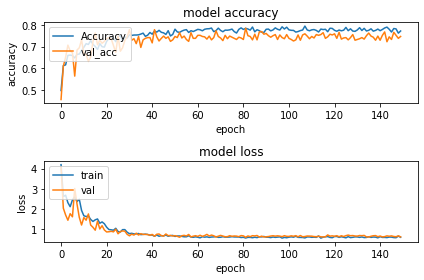

In [17]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()